<a href="https://colab.research.google.com/github/yanada1307/14IF_Multi-label-Emotion-Classification/blob/main/Proyek_PBA_Sprinkle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PROYEK PBA KELOMPOK SPRINKLE**
**Pemrosesan Bahasa Alami**

**Selasa, 23 November 2021**


1.   11S18015 - Yanada Sari Br Situmorang
2.   11S18002 - Putri Era Waty Bakara
3.   11S18010 - N. Priskila Napitupulu
4.   11S18012 - Suryani Vebhitry Siahaan
5.   11S18038 - Grace Winda N Naibaho
6.   11S18063 - Elyta Junetta Siregar





---

In [ ]:
!pip3 install datasets transformers -q

     |████████████████████████████████| 290 kB 5.2 MB/s 
     |████████████████████████████████| 3.1 MB 36.7 MB/s 
     |████████████████████████████████| 243 kB 46.2 MB/s 
     |████████████████████████████████| 132 kB 47.7 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 1.1 MB 45.7 MB/s 
     |████████████████████████████████| 895 kB 36.8 MB/s 
     |████████████████████████████████| 596 kB 44.4 MB/s 
     |████████████████████████████████| 3.3 MB 20.2 MB/s 
     |████████████████████████████████| 192 kB 44.7 MB/s 
     |████████████████████████████████| 271 kB 46.4 MB/s 
     |████████████████████████████████| 160 kB 46.6 MB/s 


In [ ]:
!pip install tez

In [ ]:
from datasets import load_dataset

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import os
import random
import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

**Load dataset go_emotions dan split menjadi train, validation, dan test**

In [ ]:
go_emotions = load_dataset("go_emotions")

data = go_emotions.data

Downloading:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

No config specified, defaulting to: go_emotions/simplified


Downloading:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/203k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/201k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

In [ ]:
print(train.shape, valid.shape, test.shape)

(43410, 3) (5426, 3) (5427, 3)


In [ ]:
train.head() 

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


**Convert dataset menjadi representasi one-hot**

In [ ]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

n_labels = len(mapping)

In [ ]:
def one_hot_labels(df):
    dict_labels= []
    for i in tqdm(range(len(df))):
        d = [0]*n_labels
        labels = df.iloc[i]["labels"]
        
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
        
    return pd.DataFrame(dict_labels)

In [ ]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [ ]:
train_oh_labels.shape

(43410, 28)

In [ ]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

**Cek kembali datanya**

In [ ]:
print(train.shape, valid.shape, test.shape)

(43410, 31) (5426, 31) (5427, 31)


In [ ]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


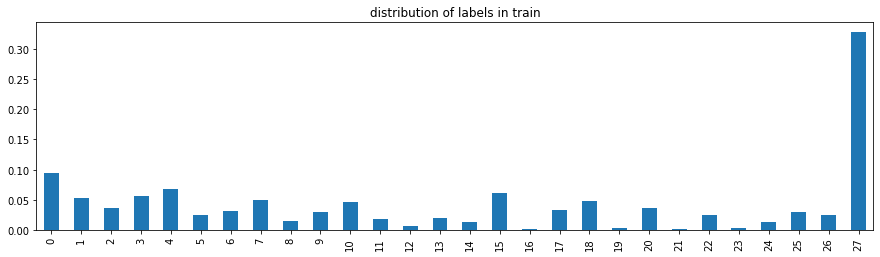

In [ ]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

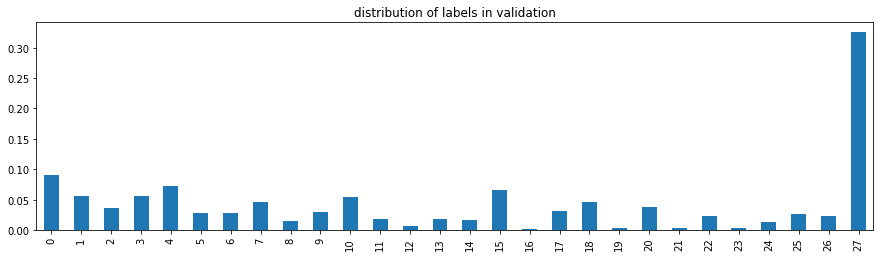

In [ ]:
fig = plt.figure(figsize=(15, 13))

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

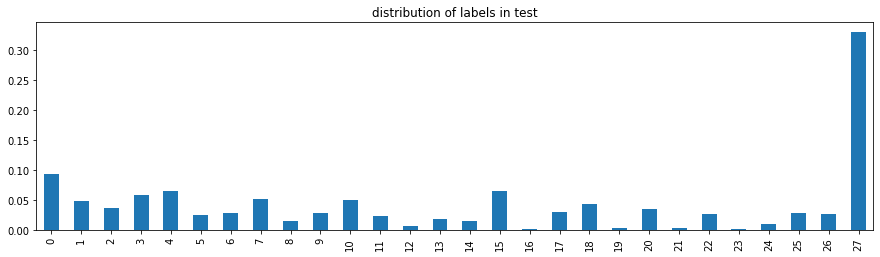

In [ ]:
fig = plt.figure(figsize=(15, 13))

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [ ]:
def inspect_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]
    
    print(f"examples from {sentiment}")
    print()
    for text in samples["text"]:
        print(text)
        print("---")

**Beberapa ulasan dari emotions**

In [ ]:
inspect_data(0)

examples from admiration

So cute!
---
Wait. Is this a parenting book with a typo? Because this seems to be a great approach to use with a toddler.
---
You. Are. Awesome. Also, congratulations on the baby!!!!
---
The sad thing is, relatively speaking these are actually pretty good living conditions. Check out Harris Ranch.
---
He looks especially cute in the glasses.
---


In [ ]:
inspect_data(1)

examples from amusement

Oh I haven’t even found those! That’s hilarious though.
---
Yay! Mine’s Cymbalta and Lamictal with a dash of Ativan lol
---
Well this hurt tonight but it could have been worse. Plus the bears choked. LOL. Offset the hurt a bit.
---
LOL men don't have feelings ;)
---
Funny that you name her when shes one of the only judges that uses her brain and ethics to make decisions.
---


In [ ]:
inspect_data(2)

examples from anger

annoyed at most
---
Damn these refs actually fucking hate us.
---
If you eat plants, you are eating animal’s food. That is so cruel!
---
What the fuck who likes cold
---
Dude wtf that was definitely off Brooklyn
---


In [ ]:
inspect_data(3)

examples from annoyance

BITCH HER PROMO EVEN DID SCREAMS LIKE A WINNER!!!!
---
there's no ventilation shafts in the dumb things, block the exits and make a bonfire.
---
it depends on the page you moron.
---
It’s like you guys actually **want** a dictator.
---
..... That would seem like the ultimate way to get rejected and never spoken to again.
---


In [ ]:
inspect_data(4)

examples from approval

I could not agree with you more! These selfish women crying abuse to manipulate.
---
It’s called concern trolling. Don’t be so gullible and quick to politicize everything.
---
Every game counts for the Kings tho. Suns are out if the playoff race and this is a must win for the Kings. BOL!
---
You just going into the posse menu and buy the persistent posse. It costs $200. Good luck ❤️
---
I know what I said son
---


In [ ]:
inspect_data(5)

examples from caring

I'm having the same problem. Hoping that there is some good advice in response to this! Hugs though hon, I feel your pain.
---
Same! Protect yourself as much as you can. I also clean the phone and the case :D
---
Do not destroy your life bc of feelings for an underaged person. think back to when you were 14
---
Sorry you are still being messaged by ugly guys, that must be really tough, you are brave for still using the site sweatie 
---
Welcome to the gloaming. Yes.
---


**Menetukan kumpulan data PyTorch**

In [ ]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35
 
    def __len__(self):
        return len(self.texts)

    
    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]

        inputs = self.tokenizer.encode_plus(text,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

**Mendefinisikan Tez** 

In [ ]:
class EmotionClassifier(tez.Model):
    def __init__(self, num_train_steps, num_classes):
        super().__init__()
        self.bert = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"

In [ ]:
    def fetch_optimizer(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        opt = AdamW(optimizer_parameters, lr=3e-5)
        return opt

In [ ]:
    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=0, num_training_steps=self.num_train_steps
        )
        return sch
    
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.BCEWithLogitsLoss()(outputs, targets.float())

In [ ]:
def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        
        outputs = torch.sigmoid(outputs)
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        fpr_micro, tpr_micro, _ = metrics.roc_curve(targets.ravel(), outputs.ravel())
        auc_micro = metrics.auc(fpr_micro, tpr_micro)
        return {"auc": auc_micro}

In [ ]:
def forward(self, ids, mask, targets=None):
        o_2 = self.bert(ids, attention_mask=mask)["pooler_output"]
        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc

**Melai Pelatihan**

In [ ]:
train_dataset = GoEmotionDataset(train.text.tolist(), train[range(n_labels)].values.tolist())
valid_dataset = GoEmotionDataset(valid.text.tolist(), valid[range(n_labels)].values.tolist())

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/500 [00:00<?, ?B/s]

In [ ]:
n_train_steps = int(len(train) / 32 * 10)
model = EmotionClassifier(n_train_steps, n_labels)

tb_logger = tez.callbacks.TensorBoardLogger(log_dir="logs/")
es = tez.callbacks.EarlyStopping(monitor="valid_loss", model_path="export/model.bin")

Downloading:   0%|          | 0.00/98.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing SqueezeBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.fit(train_dataset,
          valid_dataset, 
          train_bs=64,
          device="cuda", 
          epochs=8, 
          callbacks=[tb_logger, es], 
          fp16=Trues, 
          n_jobs=12)

In [ ]:
# train model
model.fit(
    train_dataset,
    valid_dataset=valid_dataset,
    train_bs=32,
    device="cuda",
    epochs=4,
    callbacks=[tb_logger, es],
    fp16=True
)

# save model
model.save("model.bin")

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
model.fit(train_dataset,
          valid_dataset, 
          train_bs=64,
          device="cuda", 
          epochs=8, 
          callbacks=[tb_logger, es], 
          fp16=True, 
          n_jobs=10)

In [ ]:
model.fit(train_dataset,
          valid_dataset, 
          train_bs=32,
          device="cuda", 
          epochs=4, 
          callbacks=[es], 
          fp16=True
        )

model.save("model.bin")